# Analiza kretanja masine

- cilj je na osnovu skupa anotiranih tacaka nauciti algoritam da generise mapu poslova
- 1: obuciti NN tako da ume da prepoznake tacke koje pripadaju liniji i krivoj (RAD SINTEZA)
- 2: grupisati tacke u fazi linije (fazi linija je odredjena pocetnom i krajnom tackom te koeficientom pravca)
- 3: iskoristi SOM da bi se grupisali svi koeficienti pravca
- 4: na osnovu dobijenih rezultata izvrsiti korekciju fazi linija
- 5: prepoznavanje tacaka koje pripadaju servisnim putevima linearna regresija

## 1. ucitavanje podataka i format

```
0 Date	
1 Time	
2 AbC	
3 AC	
4 CdE	
5 CE	
6 AbcdE	
7 AE	
8 speed	
9 cog	
10 lon	   - koordinate tacke C
11 lat	
12 segment - redni broj segmenta	
13 class - [line, curve]
```

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as linalg
%matplotlib inline

def load_data(file_name):
    with open(file_name, 'r') as f:
        data = f.read()
    data_set = []    
    lines = data.split('\n')
    p = 0
    n = 0
    for line in lines[1:]:
        parts = line.split('\t')
        if len(parts)>1:
            item = []
            for i in range(1, 13):
                item.append(float(parts[i]))
            if(parts[13] == 'line'):
                item.append(float(0))
            else:
                item.append(float(1))            
            
            data_set.append(np.array(item))            
            if(parts[13] == 'line'):
                p += 1
            else:
                n += 1
    print p, n
    data_set = np.array(data_set)
    return data_set


In [17]:
data = load_data('data/rad_podaci_etran.csv')

16541 1739


## Data

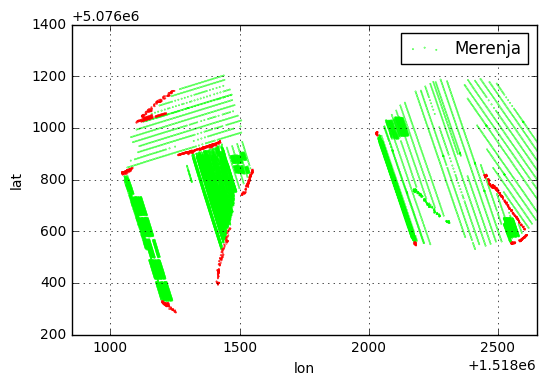

In [19]:
klon = 78847
klat = 111132

color = [(item, (1-item), 0) for item in data[1:,12]]

plt.scatter(klon*data[1:,9], klat*data[1:,10], color=color, s=0.1, label='Merenja');
plt.legend()
plt.xlabel('lon')
plt.ylabel('lat')
plt.axis('equal')
plt.grid(True)

## Neuronska mreza za SINTEZA rad

In [59]:
from keras.models import Sequential
from keras.layers.core import Activation, Dense
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(1, input_dim=6))
#model.add(Activation('tanh'))
#model.add(Dense(1))
model.add(Activation('sigmoid'))

## Algoritam za obucavanje

In [60]:
sgd = SGD(lr=0.01, decay=0.0000001, momentum=0.7)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])


### Obucavajuci skup

In [61]:
train_rank = 1000
test_rank = 500

train_subset = np.random.choice(data[1:, :].shape[0], train_rank)
test_subset = np.random.choice(data[1:, :].shape[0], test_rank)

### Trening

In [62]:
training = model.fit(data[train_subset,1:7], data[train_subset,12], nb_epoch=5000, batch_size=100, verbose=0, validation_data=(data[test_subset,1:7], data[test_subset,12]))
print training.history['loss'][-1]

0.0470102347434


0.0470102347434


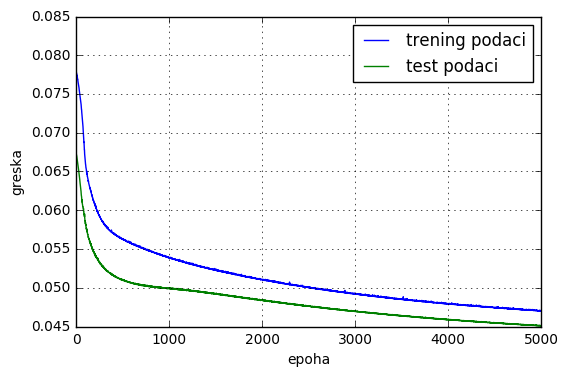

In [65]:
#['acc', 'loss', 'val_acc', 'val_loss']
print training.history['loss'][-1]

x = np.arange(0, len(training.history['loss']))

plt.plot(x, training.history['loss'], c='b', label='trening podaci')
plt.plot(x, training.history['val_loss'], c='g', label='test podaci')
plt.xlabel('epoha')
plt.legend()
plt.ylabel('greska')
plt.grid(True)


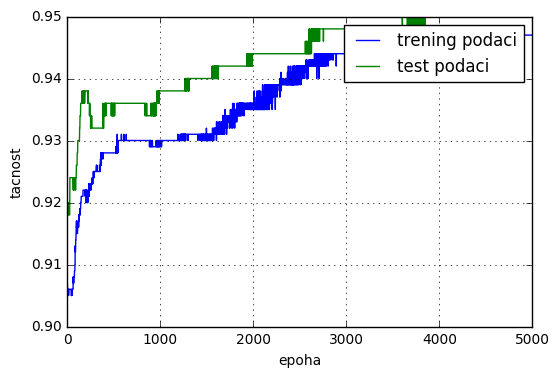

In [66]:
x = np.arange(0, len(training.history['loss']))

plt.plot(x, training.history['acc'], c='b', label='trening podaci')
plt.plot(x, training.history['val_acc'], c='g', label='test podaci')
plt.xlabel('epoha')
plt.legend()
plt.ylabel('tacnost')
plt.grid(True)


## Grupisanje tacaka u linije

